In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import talib as ta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [40]:
df = pd.read_csv('data/data.csv')
df.shape


(59271, 20)

In [41]:
# Checking for null values
df.isnull().sum()

ts_recv          0
ts_event         0
rtype            0
publisher_id     0
instrument_id    0
action           0
side             0
depth            0
price            0
size             0
flags            0
ts_in_delta      0
sequence         0
bid_px_00        0
ask_px_00        0
bid_sz_00        0
ask_sz_00        0
bid_ct_00        0
ask_ct_00        0
symbol           0
dtype: int64

## Feature Engineering

Technical Indicators used for the project include:

- Trend Indicators:
    1) Moving Averages (MA)
    2) Exponential Moving Averages (EMA)
    3) Ichimoku Cloud (ICH)
    4) Average Directional Index (ADX)
    5) Directional Index (DI)

- Momentum Indicators:
    1) Momentum (MOM)
    2) Rate of Change (ROC)
    3) Commodity Channel Index (CCI)
    4) Moving Average Convergence/Divergence (MACD)
    5) Relative Strength Index (RSI)
    6) Stochastic Oscillator (Stoch)
    
- Volume Indicators:
    1) On Balance Volume (OBV)
    2) Accumulation/Distribution Line (ADL)
    3) OBV Mean

- Volatility Indicators:
    1) Bollinger Bands (BB)
    2) Average True Range (ATR)

- Price Indicators:
    1) Time-Weighted Average Price (TWAP)
    2) VOlume-Weighted Average Price (VWAP)

In [42]:
class TechnicalIndicators:
    def __init__(self, df):
        self.df = df
    
    def add_trend_indicators(self):

        # Ichimoku Cloud components (will start from 101st index)
        self.df['conversion_line'], self.df['base_line'] = ta.TEMA(self.df['Close'], timeperiod=9), ta.TEMA(self.df['Close'], timeperiod=26)
        self.df['span_a'] = ((self.df['conversion_line'] + self.df['base_line']) / 2).shift(26)
        self.df['span_b'] = ta.SMA(self.df['Close'], timeperiod=52).shift(26)
        self.df['lagging_span'] = self.df['Close'].shift(-26) # 26 days behind

        # Exponential Moving Average (EMA)
        self.df['EMA'] = ta.EMA(df['Close'], timeperiod=20) # 20-period EMA (from 19th index)

        # Moving Average (MA) for time periods of 50 (short-term trend) and 200 (long-term trend)
        self.df['MA50'] = ta.SMA(df['Close'], timeperiod=50)
        self.df['MA200'] = ta.SMA(df['Close'], timeperiod=200)

        # Average Directional Index (ADX)
        # since ADX is calculated using +DI and -DI, let's calculate those values as well (although these values are calculated internally while calculating ADX, it's still nice to have these values for future visualizations or analysis)
        self.df['ADX'] = ta.ADX(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14) #from 28th index
        self.df['+DI'] = ta.PLUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14) #from 14th index
        self.df['-DI'] = ta.MINUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14) #from 14th index
    
    def add_momentum_indicators(self):

        # Momentum
        self.df['Momentum'] = ta.MOM(self.df['Close'], timeperiod=10) #from 10th index

        # Rate Of Change (ROC)
        self.df['ROC'] = ta.ROC(self.df['Close'], timeperiod=10)

        # Commodity Channel Index (CCI)
        self.df['CCI'] = ta.CCI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14)

        # MACD
        self.df['MACD'], self.df['MACD_signal'], self.df['MACD_hist'] = ta.MACD(self.df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

        # RSI
        self.df['RSI'] = ta.RSI(self.df['Close'], timeperiod=14)

        # Stochastic Oscillator
        self.df['Stoch_k'], self.df['Stoch_d'] = ta.STOCH(self.df['High'], self.df['Low'], self.df['Close'], fastk_period=14, slowk_period=3, slowd_period=3)

    def add_volume_indicators(self):
        
        # On Balance Volume
        self.df['OBV'] = ta.OBV(self.df['Close'], self.df['Volume'])

        # Accumulation/Distribution Line (ADL)
        self.df['ADL'] = ta.AD(self.df['High'], self.df['Low'], self.df['Close'], self.df['Volume'])

    def add_volatility_indicators(self):
        
        # Bollinger Bands (BB)
        self.df['Upper_BB'], self.df['Middle_BB'], self.df['Lower_BB'] = ta.BBANDS(self.df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

        # Average True Range (ATR)
        self.df['ATR'] = ta.ATR(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14)

    def add_price_indicators(self):
        '''
        Since the talib doesn't have a function to calculate TWAP and VWAP, I will be calculating them manually
        '''

        # Time-Weighted Average Price (TWAP) - SUM(Price * Time) / SUM(Time)
        self.df['Timestamp'] = pd.to_datetime(self.df['ts_event'])
        # calculating time differences in seconds
        self.df['Time'] = self.df['Timestamp'].diff().dt.total_seconds()
        # calculating weighted closed prices
        self.df['Weighted_Close'] = df['Close'] * df['Time']
        # calculating TWAP
        self.df['TWAP'] = self.df['Weighted_Close'].cumsum() / self.df['Time'].cumsum()

        # Volume-Weighted Average PRice (VWAP) - SUM(Price * Volume) / SUM(Volume)
        self.df['VWAP'] = (self.df['Close'] * self.df['Volume']).cumsum() / self.df['Volume'].cumsum()

    def add_all_indicators(self):
        self.add_trend_indicators()
        self.add_momentum_indicators()
        self.add_volume_indicators()
        self.add_volatility_indicators()
        self.add_price_indicators()
        return self.df


In [43]:
# Creating necessary columns to calculate techincal indicators
df['price'] = df['price'] * 1e-9
df['bid_px_00'] = df['bid_px_00'] * 1e-9
df['ask_px_00'] = df['ask_px_00'] * 1e-9

df['Close'] = df['price']
df['Open'] = df['Close'].shift(1).fillna(df['Close'])
df['Volume'] = df['size']
df['High'] = df[['bid_px_00','ask_px_00']].max(axis=1)
df['Low'] = df[['bid_px_00','ask_px_00']].min(axis=1)

ti = TechnicalIndicators(df)
df_with_indicators = ti.add_all_indicators()
market_features_df = df_with_indicators[199:].reset_index(drop=True)

pd.set_option('display.max_columns', None)
market_features_df.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol,Close,Open,Volume,High,Low,conversion_line,base_line,span_a,span_b,lagging_span,EMA,MA50,MA200,ADX,+DI,-DI,Momentum,ROC,CCI,MACD,MACD_signal,MACD_hist,RSI,Stoch_k,Stoch_d,OBV,ADL,Upper_BB,Middle_BB,Lower_BB,ATR,Timestamp,Time,Weighted_Close,TWAP,VWAP
0,1688371628276648256,1688371628276481637,1,2,32,T,A,0,194.00,2,0,166619,613573,194.00,194.17,853,50,6,1,AAPL,194.00,194.01,2,194.17,194.00,194.027891,194.024564,194.102973,194.151346,194.05,194.038516,194.0784,194.11920,59.901979,7.029446,9.844471,0.00,0.000000,54.545455,-0.010144,-0.013576,0.003433,39.207231,1.568627e+01,48.366013,-4698.0,-4697.734161,194.097838,194.0330,193.968162,0.094418,2023-07-03 08:07:08.276481637,0.000000,0.000000,194.159454,194.081814
1,1688371628276648256,1688371628276481637,1,2,32,T,A,0,194.00,8,130,166619,613574,194.00,194.17,851,50,5,1,AAPL,194.00,194.00,8,194.17,194.00,194.012985,194.018694,194.104036,194.148846,194.04,194.034848,194.0758,194.11860,56.814888,6.174306,8.646880,0.00,0.000000,47.381865,-0.012113,-0.013284,0.001171,39.207231,1.960784e+00,22.222222,-4698.0,-4705.734161,194.093523,194.0295,193.965477,0.099817,2023-07-03 08:07:08.276481637,0.000000,0.000000,194.159454,194.081747
2,1688371628277860493,1688371628277695844,1,2,32,T,A,0,194.00,96,130,164649,613576,194.00,194.17,843,50,5,1,AAPL,194.00,194.00,96,194.17,194.00,194.003783,194.013766,194.070098,194.144231,194.01,194.031529,194.0732,194.11805,53.948304,5.459113,7.645281,0.00,0.000000,41.374570,-0.013518,-0.013330,-0.000187,39.207231,3.671137e-14,5.882353,-4698.0,-4801.734161,194.088418,194.0260,193.963582,0.104830,2023-07-03 08:07:08.277695844,0.001214,0.235556,194.159453,194.080956
3,1688371628500840454,1688371628500675770,1,2,32,T,A,0,194.07,2,130,164684,613843,194.07,194.17,2,150,1,2,AAPL,194.07,194.00,2,194.17,194.07,194.032588,194.024091,194.043014,194.139423,194.01,194.035193,194.0722,194.11785,51.286475,4.853650,6.797352,0.07,0.036082,187.890137,-0.008880,-0.012440,0.003560,56.163576,1.372549e+01,5.228758,-4696.0,-4803.734161,194.088418,194.0260,193.963582,0.109485,2023-07-03 08:07:08.500675770,0.222980,43.273714,194.159407,194.080954
4,1688371640349690276,1688371640349525673,1,2,32,T,N,0,194.11,1,130,164603,622059,194.04,194.17,7,550,1,3,AAPL,194.11,194.07,1,194.17,194.04,194.070797,194.041291,194.024295,194.134615,194.07,194.042318,194.0720,194.11785,49.726474,4.447436,8.159829,0.04,0.020611,157.095710,-0.001955,-0.010343,0.008389,62.585521,3.529412e+01,16.339869,-4695.0,-4803.657238,194.100805,194.0290,193.957195,0.110950,2023-07-03 08:07:20.349525673,11.848850,2299.980255,194.158075,194.080956


### Technical Indicators to Label the data

In [44]:
# 0 - HOLD, 1 - BUY, 2 - SELL
def label_data(row):
    if (row['Close'] > row['MA50'] and row['Close'] > row['MA200']) or row['RSI'] < 30:
        return 1
    elif (row['Close'] < row['MA50'] and row['Close'] < row['MA200']) or row['RSI'] > 70:
        return 2
    else:
        return 0

market_features_df['label'] = market_features_df.apply(label_data, axis=1)
market_features_df = market_features_df.reset_index(drop=True)
market_features_df.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol,Close,Open,Volume,High,Low,conversion_line,base_line,span_a,span_b,lagging_span,EMA,MA50,MA200,ADX,+DI,-DI,Momentum,ROC,CCI,MACD,MACD_signal,MACD_hist,RSI,Stoch_k,Stoch_d,OBV,ADL,Upper_BB,Middle_BB,Lower_BB,ATR,Timestamp,Time,Weighted_Close,TWAP,VWAP,label
0,1688371628276648256,1688371628276481637,1,2,32,T,A,0,194.00,2,0,166619,613573,194.00,194.17,853,50,6,1,AAPL,194.00,194.01,2,194.17,194.00,194.027891,194.024564,194.102973,194.151346,194.05,194.038516,194.0784,194.11920,59.901979,7.029446,9.844471,0.00,0.000000,54.545455,-0.010144,-0.013576,0.003433,39.207231,1.568627e+01,48.366013,-4698.0,-4697.734161,194.097838,194.0330,193.968162,0.094418,2023-07-03 08:07:08.276481637,0.000000,0.000000,194.159454,194.081814,2
1,1688371628276648256,1688371628276481637,1,2,32,T,A,0,194.00,8,130,166619,613574,194.00,194.17,851,50,5,1,AAPL,194.00,194.00,8,194.17,194.00,194.012985,194.018694,194.104036,194.148846,194.04,194.034848,194.0758,194.11860,56.814888,6.174306,8.646880,0.00,0.000000,47.381865,-0.012113,-0.013284,0.001171,39.207231,1.960784e+00,22.222222,-4698.0,-4705.734161,194.093523,194.0295,193.965477,0.099817,2023-07-03 08:07:08.276481637,0.000000,0.000000,194.159454,194.081747,2
2,1688371628277860493,1688371628277695844,1,2,32,T,A,0,194.00,96,130,164649,613576,194.00,194.17,843,50,5,1,AAPL,194.00,194.00,96,194.17,194.00,194.003783,194.013766,194.070098,194.144231,194.01,194.031529,194.0732,194.11805,53.948304,5.459113,7.645281,0.00,0.000000,41.374570,-0.013518,-0.013330,-0.000187,39.207231,3.671137e-14,5.882353,-4698.0,-4801.734161,194.088418,194.0260,193.963582,0.104830,2023-07-03 08:07:08.277695844,0.001214,0.235556,194.159453,194.080956,2
3,1688371628500840454,1688371628500675770,1,2,32,T,A,0,194.07,2,130,164684,613843,194.07,194.17,2,150,1,2,AAPL,194.07,194.00,2,194.17,194.07,194.032588,194.024091,194.043014,194.139423,194.01,194.035193,194.0722,194.11785,51.286475,4.853650,6.797352,0.07,0.036082,187.890137,-0.008880,-0.012440,0.003560,56.163576,1.372549e+01,5.228758,-4696.0,-4803.734161,194.088418,194.0260,193.963582,0.109485,2023-07-03 08:07:08.500675770,0.222980,43.273714,194.159407,194.080954,2
4,1688371640349690276,1688371640349525673,1,2,32,T,N,0,194.11,1,130,164603,622059,194.04,194.17,7,550,1,3,AAPL,194.11,194.07,1,194.17,194.04,194.070797,194.041291,194.024295,194.134615,194.07,194.042318,194.0720,194.11785,49.726474,4.447436,8.159829,0.04,0.020611,157.095710,-0.001955,-0.010343,0.008389,62.585521,3.529412e+01,16.339869,-4695.0,-4803.657238,194.100805,194.0290,193.957195,0.110950,2023-07-03 08:07:20.349525673,11.848850,2299.980255,194.158075,194.080956,0


In [45]:
# Class imbalance
market_features_df['label'].value_counts()

label
1    36335
2    13307
0     9430
Name: count, dtype: int64

## Model Training Using Transformer Encoder (Fine-Tuned with a Classification Head)

In [46]:
# Transformer Encoder Model
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout=0.3):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_key_padding_mask=None):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = x[-1]  # Taking the last sequence element
        x = self.dropout(x)
        return self.classifier(x)


In [47]:
# Training function
def train(model, train_loader, criterion, optimizer, device, class_weights):
    model.train()
    total_loss = 0
    for batch_data, batch_targets in train_loader:
        batch_data, batch_targets = batch_data.to(device), batch_targets.to(device)
        
        # Creating a mask for the padded elements
        mask = (batch_data.sum(dim=-1) != 0).float()
        
        optimizer.zero_grad()
        outputs = model(batch_data, src_key_padding_mask=(mask == 0))
        
        loss = criterion(outputs, batch_targets)
        weights = class_weights[batch_targets].to(device)
        weighted_loss = (loss * weights).mean()
        
        weighted_loss.backward()
        optimizer.step()
        total_loss += weighted_loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(model, test_loader, criterion, device, class_weights):
    model.eval()
    total_loss = 0
    all_predictions, all_targets = [], []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_data, batch_targets in test_loader:
            batch_data, batch_targets = batch_data.to(device), batch_targets.to(device)
            
            # Creating a mask for the padded elements
            mask = (batch_data.sum(dim=-1) != 0).float()
            
            outputs = model(batch_data, src_key_padding_mask=(mask == 0))
            loss = criterion(outputs, batch_targets)
            weights = class_weights[batch_targets].to(device)
            weighted_loss = (loss * weights).mean()
            total_loss += weighted_loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_targets.size(0)
            correct += (predicted == batch_targets).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    accuracy = correct / total
    return total_loss / len(test_loader), accuracy, all_predictions, all_targets

# Defining the features
features = ["Close", "Open", "Volume", "High", "Low", "conversion_line", "base_line", "span_a", "span_b", "EMA", "ADX", "+DI", "-DI", "Momentum", "ROC", "CCI", "MACD", "MACD_signal",
            "MACD_hist", "RSI", "Stoch_k", "Stoch_d", "OBV", "ADL", "Upper_BB", "Middle_BB", "Lower_BB", "ATR", 'MA50', 'MA200', "Weighted_Close", "TWAP", "VWAP"]

class PrepareDataset(Dataset):
    def __init__(self, data, targets, seq_length):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if index < self.seq_length:
            pad = torch.zeros((self.seq_length - index, self.data.shape[1]))
            sequence = torch.cat((pad, self.data[:index+1]), dim=0)
        else:
            sequence = self.data[index-self.seq_length+1:index+1]
        
        return sequence, self.targets[index]


# Data Preprocessing
def preprocess_data(df, seq_length):

    X = df[features].values
    y = df['label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # class weights
    class_counts = np.bincount(y_train)
    class_weights = 1. / class_counts
    class_weights = class_weights / np.sum(class_weights)  # Normalizing weights
    class_weights = torch.FloatTensor(class_weights)

    train_dataset = PrepareDataset(X_train, y_train, seq_length)
    test_dataset = PrepareDataset(X_test, y_test, seq_length)

    return train_dataset, test_dataset, class_weights

def custom_collate(batch):
    # Separating sequences and labels
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Padding sequences to the same length
    padded_sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    
    # Converting labels to tensor
    labels = torch.LongTensor(labels)
    
    return padded_sequences, labels

# Training loop
def main():
    # Hyperparameters
    seq_length = 20
    batch_size = 16  
    d_model = 128  
    nhead = 8
    num_layers = 3
    dim_feedforward = 512
    num_epochs = 20  
    learning_rate = 0.0005  

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Loading and preprocessing the data
    train_dataset, test_dataset, class_weights = preprocess_data(market_features_df, seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=custom_collate)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate)

    class_weights = class_weights.to(device)

    # Initializing the  model
    input_dim = len(features)
    num_classes = 3  # HOLD, BUY, SELL
    model = TransformerEncoder(input_dim, num_classes, d_model, nhead, num_layers, dim_feedforward).to(device)

    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_loss = float('inf')
    patience = 10
    num_epochs_with_no_improvement = 0

    # Training loop
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device, class_weights)
        test_loss, test_accuracy, _, _ = evaluate(model, test_loader, criterion, device, class_weights)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        if test_loss < best_loss:
            best_loss = test_loss
            num_epochs_with_no_improvement = 0
            torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        else:
            num_epochs_with_no_improvement += 1

        if num_epochs_with_no_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in test loss for {patience} epochs')
            break

        scheduler.step()

    # Saving the model
    torch.save(model.state_dict(), "transformer_agent.pth")

if __name__ == "__main__":
    main()

/Users/anirudhnuti/Documents/BH_Assignment/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/20, Train Loss: 0.1710, Test Loss: 0.1421, Test Accuracy: 0.7898
Epoch 2/20, Train Loss: 0.1386, Test Loss: 0.1269, Test Accuracy: 0.7953
Epoch 3/20, Train Loss: 0.1175, Test Loss: 0.0902, Test Accuracy: 0.8305
Epoch 4/20, Train Loss: 0.1006, Test Loss: 0.0832, Test Accuracy: 0.8593
Epoch 5/20, Train Loss: 0.0898, Test Loss: 0.0727, Test Accuracy: 0.9014
Epoch 6/20, Train Loss: 0.0824, Test Loss: 0.0623, Test Accuracy: 0.9032
Epoch 7/20, Train Loss: 0.0764, Test Loss: 0.0674, Test Accuracy: 0.9016
Epoch 8/20, Train Loss: 0.0707, Test Loss: 0.0534, Test Accuracy: 0.9232
Epoch 9/20, Train Loss: 0.0660, Test Loss: 0.0609, Test Accuracy: 0.9187
Epoch 10/20, Train Loss: 0.0614, Test Loss: 0.0514, Test Accuracy: 0.9253
Epoch 11/20, Train Loss: 0.0559, Test Loss: 0.0513, Test Accuracy: 0.9265
Epoch 12/20, Train Loss: 0.0513, Test Loss: 0.0425, Test Accuracy: 0.9305
Epoch 13/20, Train Loss: 0.0471, Test Loss: 0.0473, Test Accuracy: 0.9358
Epoch 14/20, Train Loss: 0.0430, Test Loss: 0.0

## Predictions

In [50]:
def make_predictions(model, dataset, device, seq_length):
    model.eval()
    predictions = []
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        for batch_data, _ in data_loader:
            batch_data = batch_data.to(device)
            output = model(batch_data)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())

    return predictions

# Hyperparameters
seq_length = 20
batch_size = 16  
d_model = 128  
nhead = 8
num_layers = 3
dim_feedforward = 512
num_epochs = 20  
learning_rate = 0.0005  
input_dim = len(features)
num_classes = 3  # HOLD, BUY, SELL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = market_features_df[features].values
y = market_features_df['label'].values

dataset = PrepareDataset(X, y, seq_length)

model = TransformerEncoder(input_dim, num_classes, d_model, nhead, num_layers, dim_feedforward).to(device)
model.load_state_dict(torch.load("best_model_checkpoint.pth"))
predictions = make_predictions(model, dataset, device, seq_length)

# Now predictions should have the same length as your original dataset
assert len(predictions) == len(X), "Predictions length does not match dataset length"

print(f"Length of predictions: {len(predictions)}")
print(f"Length of original dataset: {len(X)}")

/Users/anirudhnuti/Documents/BH_Assignment/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/var/folders/w_/gx_mdgh125lfzwmrfrb9cf280000gn/T/ipykernel_44909/1021993794.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickl

Length of predictions: 59072
Length of original dataset: 59072


## Evaluation

Accuracy: 0.9567
Precision: 0.9591
Recall: 0.9567
F1-score: 0.9575


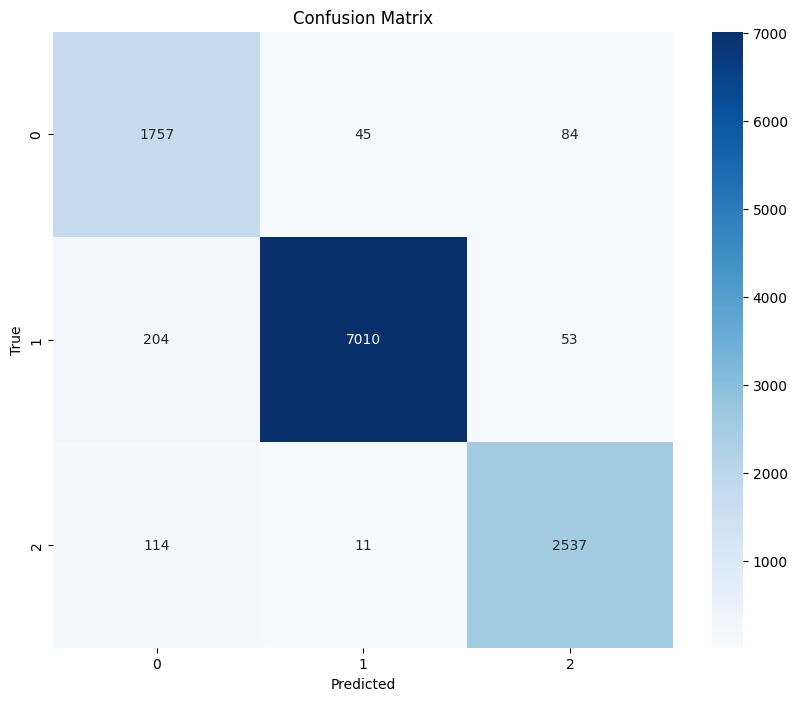

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # After training and evaluation - Classification Report
    print(classification_report(y_true, y_pred, target_names=['HOLD', 'BUY', 'SELL']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# After training
train_dataset, test_dataset, class_weights = preprocess_data("market_df.csv", seq_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate)

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(reduction='none')

model.eval()
_, _, all_predictions, all_targets = evaluate(model, test_loader, criterion, device, class_weights)
calculate_metrics(all_targets, all_predictions)

In [ ]:
# Appending the predictions into the original dataframe
market_features_df['prediction'] = predictions

In [ ]:
# Saving the dataframe to CSV
market_features_df.to_csv('df_with_predictions.csv')